# Figure 2: Do LLMs replicate the sparsity effect?

In [124]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce
import kendall_w.kendall_w as kw
import scipy.stats
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import seaborn_image as isns

sns.set_theme()

In [40]:
def ECDF_transform(arr: np.ndarray):
    return ECDF(arr)(arr)

### Data-loading function

In [103]:
def get_results(
    model="gpt2_xl",
    study="composlang",
    paradigm="logprobs",
    basedir=Path("./llm-results/"),
):
    [resultsdir] = (basedir / study).glob("benchmark-cfg=*")
    results = list(resultsdir.glob(f"eval={paradigm}*/model={model}/results.csv"))
    results = [pd.read_csv(r, index_col=0) for r in results]
    if len(results) == 2:
        results = pd.merge(*results)
    elif len(results) == 1:
        results = results[0]
    else:
        raise ValueError(f"Found {len(results)} results")

    results = results[(results.arank >= 0) & (results.nrank >= 0)]

    if paradigm == "logprobs":
        levels = ("metadata", model)
        model_columns = ["logp_A", "logp_N", "logp_N_A"]
        metadata_columns = results.columns.difference(model_columns)

        mii = pd.MultiIndex.from_tuples(
            tuples=[("metadata", c) for c in results.columns if c in metadata_columns]
            + [(model, c) for c in results.columns if c in model_columns],
            # names=levels,
        )
        results.columns = mii
        # results["metadata", "model"] = model

        col = "logp_N_A"
        ecdf = ECDF_transform(results[model, col])
        results[model, f"ecdf_{col}"] = ecdf

        results[model, "pmi"] = (
            results[model, "logp_N_A"] - results[model, "logp_N"]
        ) / math.log(2)

    else:
        raise NotImplementedError(f"paradigm={paradigm}!=logprobs")

    return results

In [79]:
models = ["gpt2_xl", "phi_2", "mpt_7b", "mpt_7b_chat"]

In [104]:
mpt7bchat = get_results(model="mpt_7b_chat")

In [105]:
mpt7bchat

metadata                       mpt_7b_chat                      \
          adjective      noun arank nrank      logp_A    logp_N  logp_N_A   
20027         other    people     0     0  -11.875000  -7.40625  -2.03125   
20028         other      time     0     1  -11.875000 -11.37500  -7.28125   
20029         other     years     0     2  -11.875000 -11.37500 -11.56250   
20030         other      year     0     3  -11.875000 -12.62500 -12.06250   
20031         other       way     0     4  -11.875000 -12.62500 -11.06250   
...             ...       ...   ...   ...         ...       ...       ...   
1020022  unfamiliar      beer   999   995  -16.835938 -14.09375 -10.81250   
1020023  unfamiliar    option   999   996  -16.835938 -12.62500 -10.06250   
1020024  unfamiliar       key   999   997  -16.835938 -12.37500  -8.81250   
1020025  unfamiliar  exchange   999   998  -16.835938 -13.12500  -9.56250   
1020026  unfamiliar     facts   999   999  -16.835938 -14.62500  -8.81250   

                                 
        ecdf_logp_N_A       pmi  
20027        0.999653  7.754486  
20028        0.958600  5.906033  
20029        0.550016 -0.270505  
20030        0.470481  0.811516  
20031        0.626445  2.254211  
...               ...       ...  
1020022      0.663396  4.733843  
1020023      0.761914  3.696906  
1020024      0.881969  5.139601  
1020025      0.816887  5.139601  
1020026      0.881969  8.385665  

[1000000 rows x 9 columns]

In [200]:
def construct_mat(df, col="pmi"):
    model = df.columns[-1][0]
    mat = np.zeros((1000, 1000))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        mat[row.loc[("metadata", "arank")], row.loc[("metadata", "nrank")]] = row.loc[
            (model, col)
        ]
    return mat

In [126]:
mat_obs = pd.read_pickle("./simulate-comb-A-N/matrix.pkl")

In [188]:
mat_obs_dense = mat_obs[:1_000, :1_000].todense()

/tmp/ipykernel_112429/1999389497.py:2: RuntimeWarning: divide by zero encountered in log
  np.log(mat_obs_dense ),


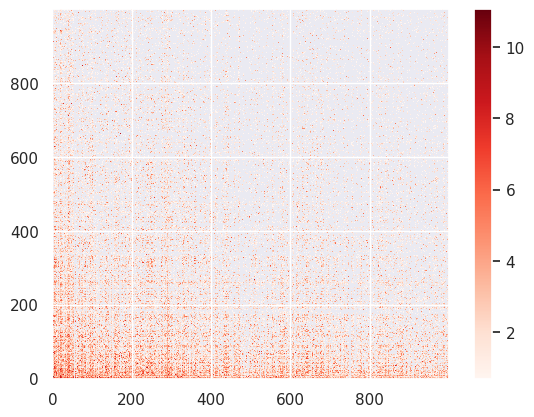

In [197]:
plt.imshow(
    np.log(mat_obs_dense),
    cmap="Reds",
    origin="lower",
    interpolation=None,
    # interpolation="bilinear",
    interpolation_stage="rgba",
    aspect="auto",
)
plt.colorbar()
plt.show()

In [201]:
mat = construct_mat(mpt7bchat, col="logp_N_A")

  0%|          | 0/1000000 [00:00<?, ?it/s]

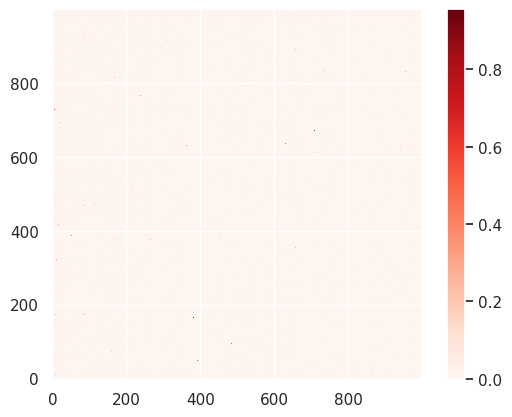

In [207]:
plt.imshow(np.e**mat, cmap="Reds", interpolation="none", origin="lower")
plt.colorbar()

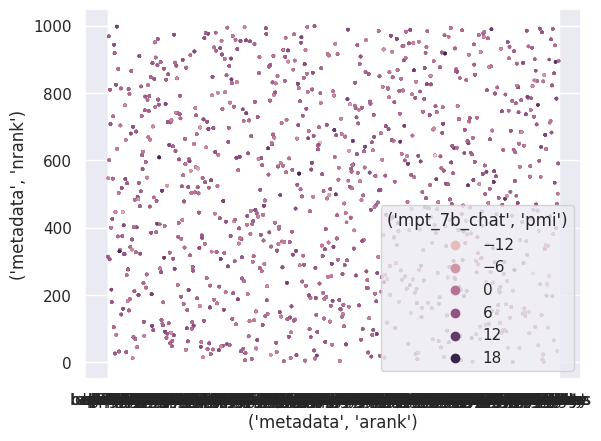

In [82]:
ax = sns.scatterplot(
    data=mpt7bchat.sample(10_000),
    x=("metadata", "arank"),
    y=("metadata", "nrank"),
    # x=("mpt_7b_chat", "logp_N_A"),
    # x=("mpt_7b_chat", "logp_A"),
    # y=("mpt_7b_chat", "logp_A"),
    # y=("mpt_7b_chat", "logp_N"),
    # y=("mpt_7b_chat", "pmi"),
    edgecolor=None,
    s=5,
    hue=("mpt_7b_chat", "pmi"),
)

plt.show()

In [7]:
mpt7bchat.sort_values(by="logp_N_A", ascending=False)

,adjective,noun,arank,nrank,logp_A,logp_N,logp_N_A
862243,affirmative,action,842,216,-14.644531,-13.8750,-0.045410
973159,crude,oil,953,132,-14.968750,-12.6250,-0.099121
672196,outer,space,652,169,-15.125000,-11.1250,-0.121582
173097,nuclear,war,153,70,-11.625000,-10.1250,-0.154297
231186,negative,interest,211,159,-12.375000,-11.6250,-0.158203
...,...,...,...,...,...,...,...
522778,universal,toolong,502,751,-12.375000,-24.1875,-31.062500
361778,unable,toolong,341,751,-12.500000,-24.1875,-31.125000
247778,mental,toolong,227,751,-13.375000,-24.1875,-31.562500
236778,worst,toolong,216,751,-15.851562,-24.1875,-31.625000


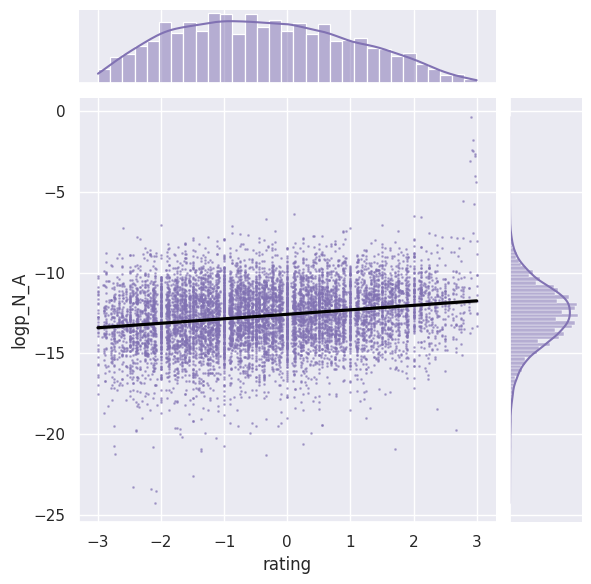

In [128]:
sns.jointplot(
    data=gptlogp,
    y="logp_N_A",
    x="rating",
    kind="reg",
    scatter_kws={"s": 1, "alpha": 0.5},
    line_kws={"color": "black"},
    color="m",
    ci=99,
    # hue="trial_type",
    # edgecolor=None,
    # s=1,
)

In [98]:
gptlogpall = get_results(study="composlang", model="gpt2_xl", paradigm="logprobs")
gptlogpall = gptlogpall[(gptlogpall["arank"] >= 0) & (gptlogpall["nrank"] >= 0)]

In [99]:
phi2logpall = get_results(study="composlang", model="phi_2", paradigm="logprobs")
phi2logpall = phi2logpall[(phi2logpall["arank"] >= 0) & (phi2logpall["nrank"] >= 0)]

<AxesSubplot:xlabel='nrank', ylabel='arank'>

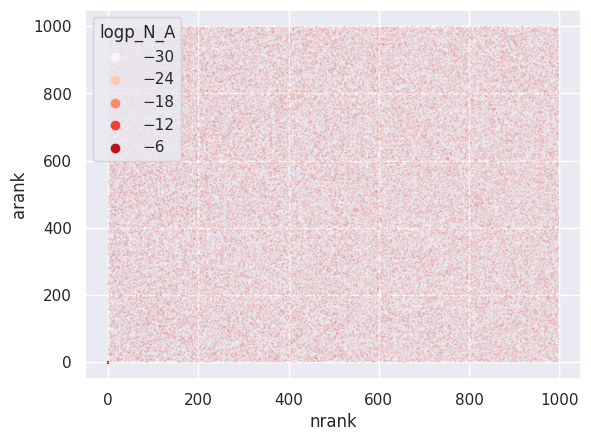

In [8]:
sns.scatterplot(
    data=mpt7bchat.sample(100_000),
    x="nrank",
    y="arank",
    hue="logp_N_A",
    edgecolor=None,
    s=1,
    alpha=0.1,
    palette="Reds",
)

In [100]:
view = pd.merge(gptlogpall, phi2logpall, on=["id"])

In [103]:
view.sample(10)

,adjective_x,noun_x,arank_x,nrank_x,logp_N_A_x,adjective_y,noun_y,arank_y,nrank_y,logp_N_A_y
id,,,,,,,,,,
643637,harsh,streets,643,637,-11.1875,harsh,streets,643,637,-11.912045
537704,behavioral,hell,537,704,-10.3750,behavioral,hell,537,704,-13.732407
551745,lowest,truck,551,745,-11.8125,lowest,truck,551,745,-10.664518
566587,islamic,investigation,566,587,-11.8125,islamic,investigation,566,587,-12.811707
508967,joint,authorities,508,967,-9.7500,joint,authorities,508,967,-9.600072
42049,whole,side,42,49,-9.6875,whole,side,42,49,-8.653444
750998,unprecedented,exchange,750,998,-9.5000,unprecedented,exchange,750,998,-10.237356
2183,new,summer,2,183,-9.1875,new,summer,2,183,-11.083316
691020,tribal,work,691,20,-8.9375,tribal,work,691,20,-8.869001


<AxesSubplot:xlabel='logp_N_A_x', ylabel='logp_N_A_y'>

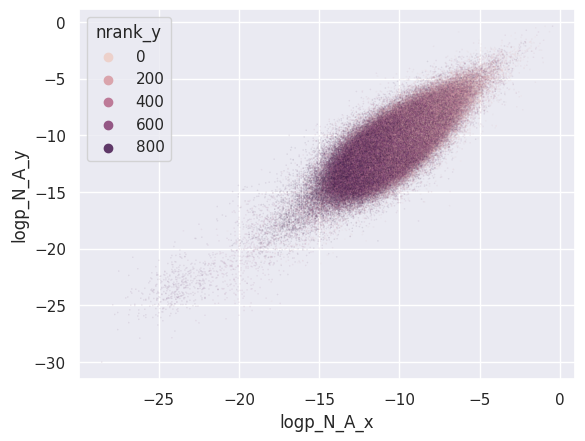

In [106]:
sns.scatterplot(
    data=view.sample(500_000),
    x="logp_N_A_x",
    y="logp_N_A_y",
    hue="nrank_y",
    edgecolor=None,
    s=1,
    alpha=0.1,
    # palette="Reds",
)

<AxesSubplot:xlabel='logp_N_A', ylabel='logp_N'>

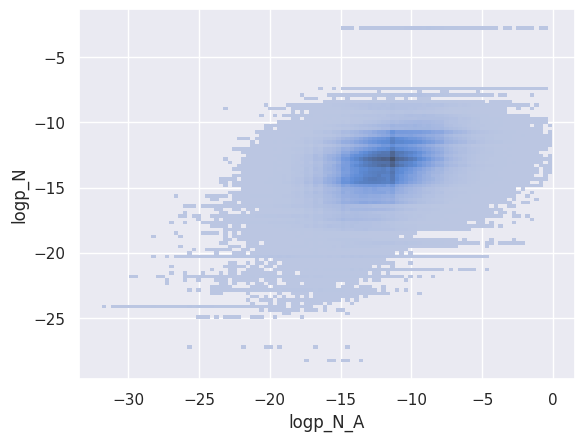

In [19]:
sns.histplot(
    data=mpt7bchat,
    x="logp_N_A",
    y="logp_N",
    # hue="trial_type",
    # edgecolor=None,
    # s=1,
    # alpha=0.1,
    bins=100,
)

In [134]:
gptlogp.apply(lambda x: x["logp_N_A"] - x["logp_N"], axis=1)

0       2.5625
1       5.6875
2       3.1250
3       2.5000
4       3.3750
         ...  
9902    2.5625
9903    4.5000
9904    4.0625
9905    4.8125
9906    6.4375
Length: 9907, dtype: float64